In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import csv
import os
from scipy.signal import butter, filtfilt
#from PyEMD import EMD
import emd
import time
import pywt
import biosppy.signals.ecg as bsp_ecg
import biosppy.signals.tools as bsp_tools
from scipy.signal import medfilt
from scipy.stats import norm
from scipy.signal import firwin, lfilter, stft, istft
from scipy.io import wavfile
from scipy.signal import stft
from scipy.signal.windows import blackman
from scipy.stats import skew, kurtosis

from utils import print_signal_qrs, print_signal, calcul_f1, perf

In [2]:
def print_signal(signal, description= "A"):
    print(f"signal de longueur: {len(signal)}")
    plt.figure(figsize=(18,8))
    plt.plot(signal)
    plt.title(label= description)
    plt.show()

In [3]:
def reduce_baseline_wandering(ecg_signal, fs):
    d1 = int(0.5 * fs)
    
    if d1 % 2 == 0:
        d1 += 1
        
    median_filtered = medfilt(ecg_signal, kernel_size=d1)
    filtered_ecg_signal = ecg_signal - median_filtered
    
    return filtered_ecg_signal

def gaussian_weights(M, sigma=2.2):
    # Indices pour lesquels on calcule la gaussienne
    r = np.arange(1, M + 1)
    # Calcul des poids gaussiens centrés à (M+1)/2 et normalisés
    weights = norm.pdf(r, loc=(M+1)/2, scale=sigma)
    return weights / np.sum(weights)

def owa_filter(signal, M, weights):
    half_M = M // 2
    padded_signal = np.pad(signal, (half_M, half_M), 'edge')
    filtered_signal = np.zeros_like(signal)
    
    for i in range(len(signal)):
        # Fenêtre de données ordonnée
        window = np.sort(padded_signal[i:i+M])
        # Produit scalaire de la fenêtre ordonnée avec les poids
        filtered_signal[i] = np.dot(weights, window)
    return filtered_signal

def cowa_filter(signal, M1, M2, P, sigma=2.2):
    # Générer les poids pour les deux filtres OWA
    weights1 = gaussian_weights(M1, sigma)
    weights2 = gaussian_weights(M2, sigma)
    
    # Première couche de filtres OWA
    x01 = owa_filter(signal, M1, weights1)
    x02 = owa_filter(signal, M2, weights2)
    
    # Calcul final de x0(n)
    x0 = 0.5 * (x01 + x02)
    return x0

def bandpass_filter(signal, fs):
    f1 = 0.8  # Fréquence de coupure basse en Hz
    f2 = 20   # Fréquence de coupure haute en Hz
    N = int(1.55 * fs)  # Longueur du filtre
    if N % 2 == 0:
        N += 1  # Assure que N est impair
    nyquist = fs / 2
    f1 /= nyquist
    f2 /= nyquist
    beta = 5.655  # Facteur de transition de la fenêtre de Kaiser
    taps = firwin(N, [f1, f2], window=('kaiser', beta), pass_zero=False)
    x1 = filtfilt(taps, 1.0, signal)
    return x1

def diff_and_square(signal):
    derivative = np.diff(signal)
    squared_signal = derivative ** 2
    return squared_signal


def smooth_signal(signal, fs):
    M = int(0.160 * fs)  # Longueur du filtre MA
    d2 = int(0.03 * fs)  # Longueur du filtre médian
    
    if M % 2 == 0:
        M += 1
    if d2 % 2 == 0:
        d2 += 1
    
    x3 = np.convolve(signal, np.ones(M)/M, mode='same')
    x = medfilt(x3, kernel_size=d2)
    return x

signal de longueur: 200


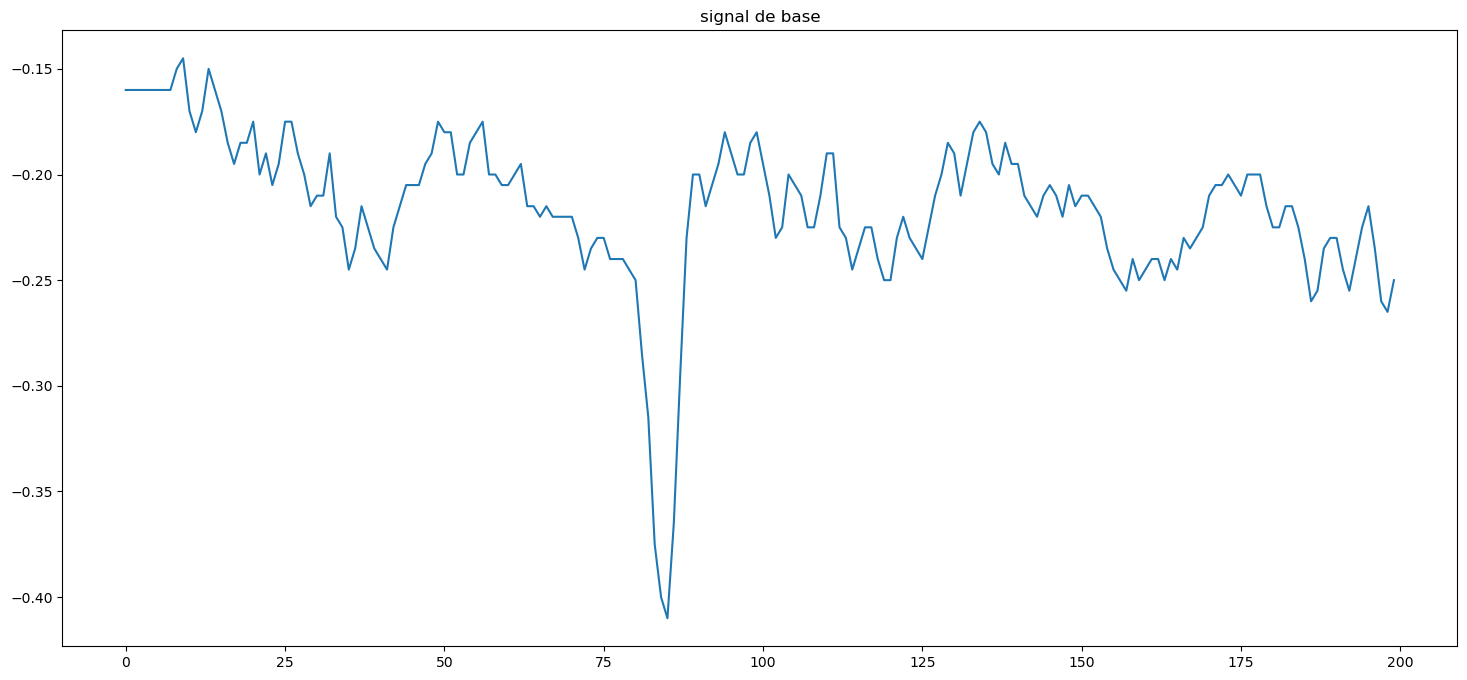

signal de longueur: 200


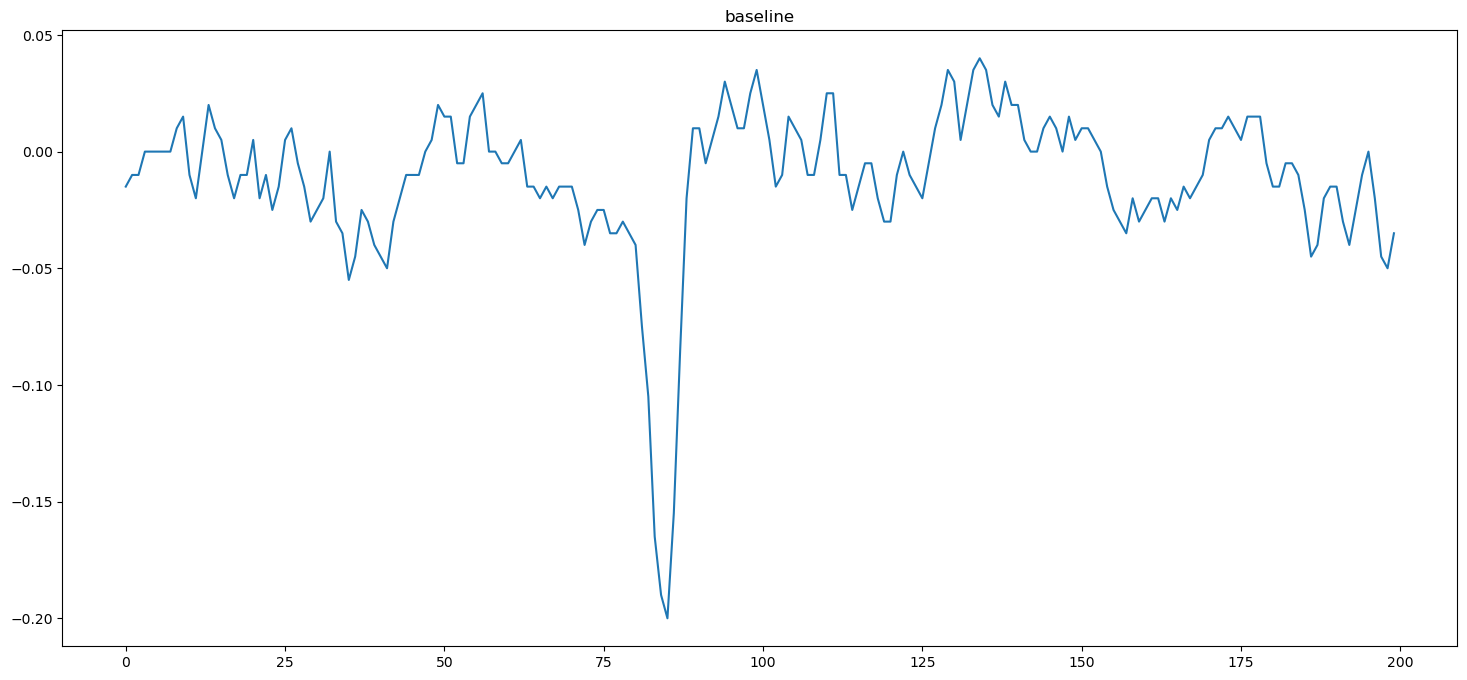

signal de longueur: 200


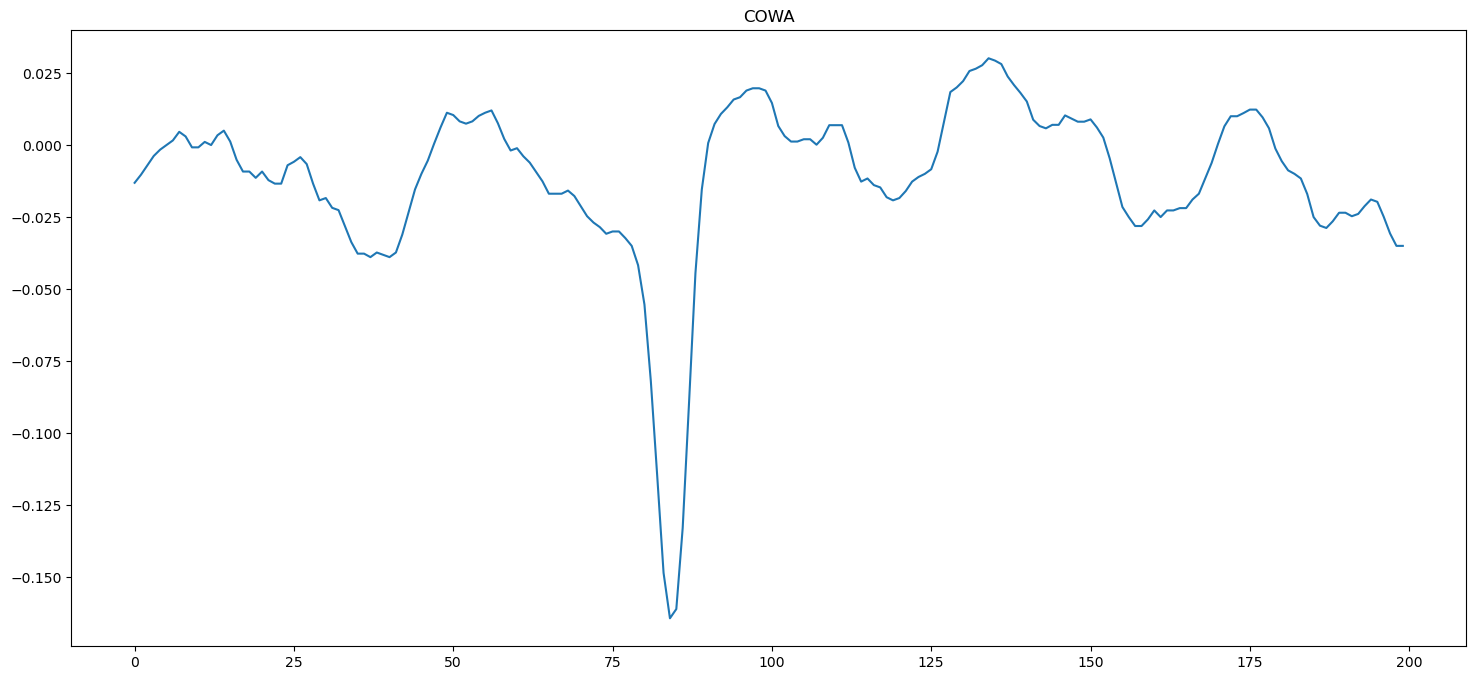

signal de longueur: 200


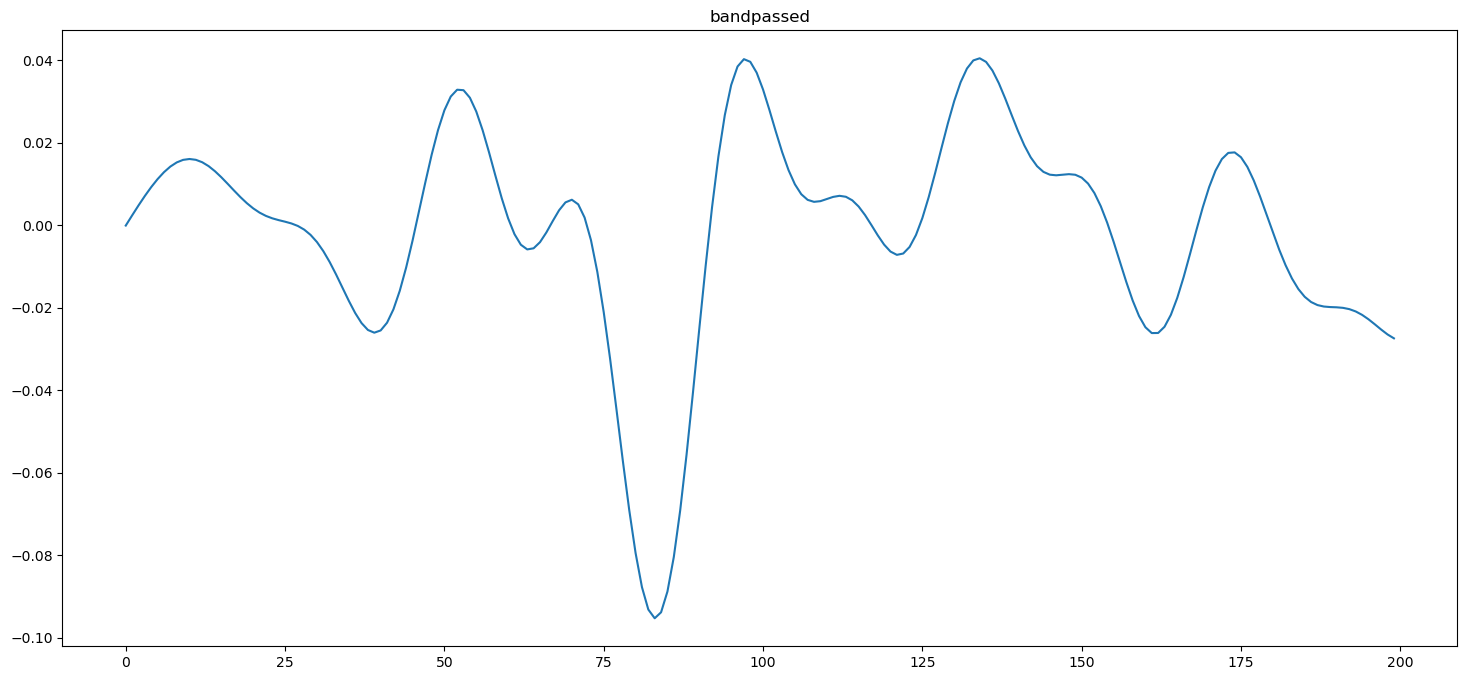

signal de longueur: 200


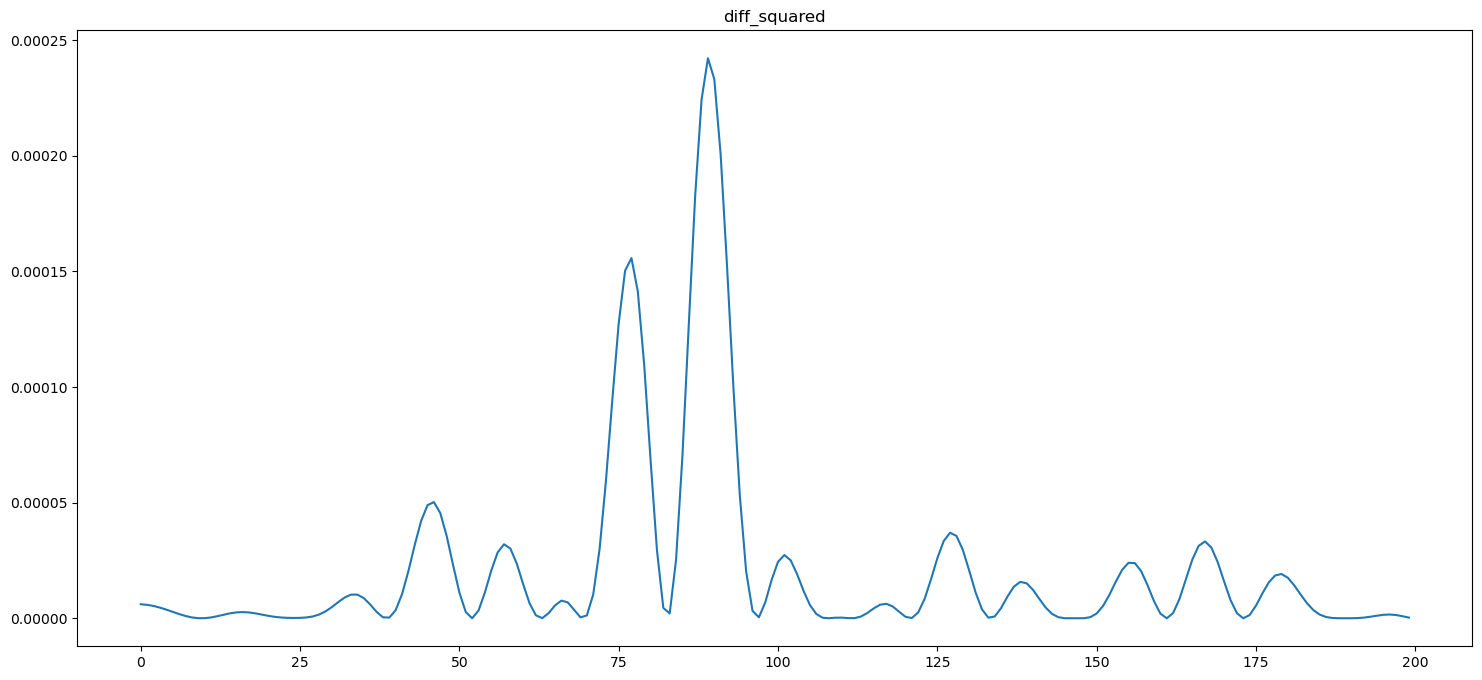

signal de longueur: 200


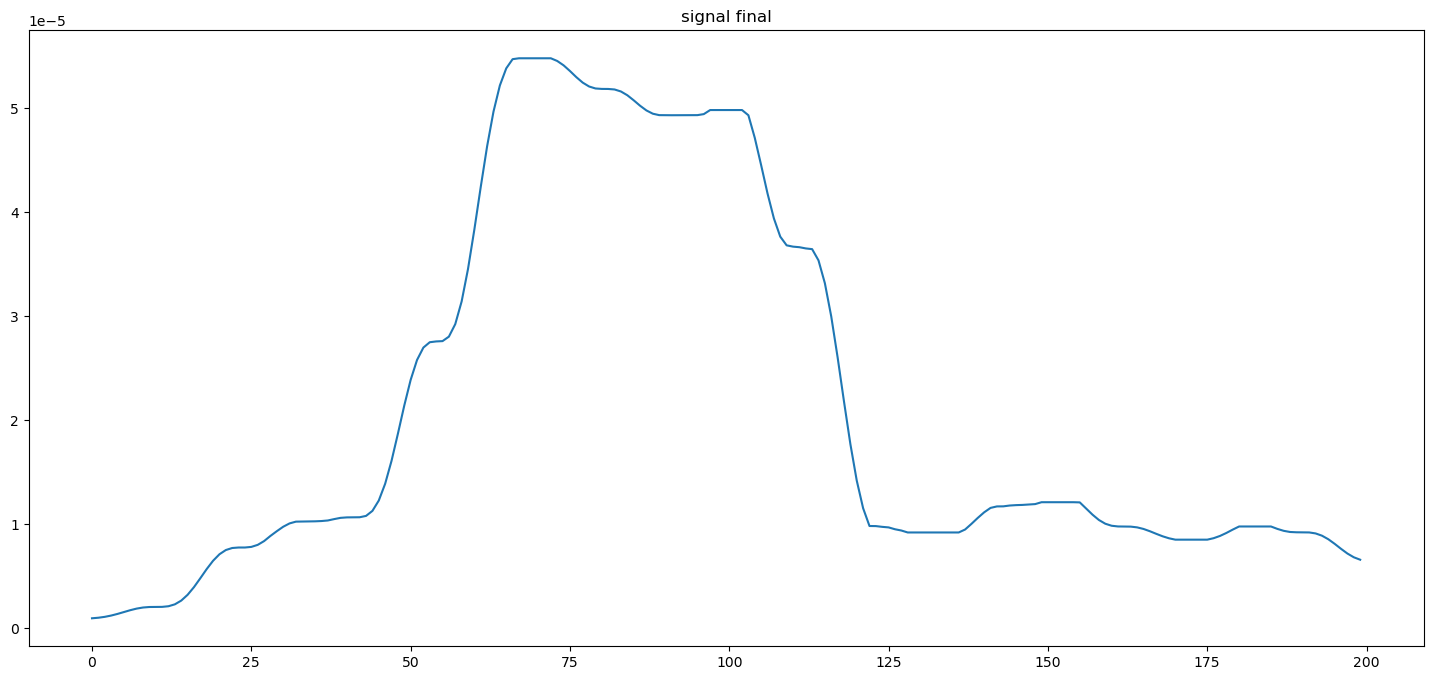

In [8]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/101.csv') #207
ecg_signal = np.array(df["V1"], dtype=np.float32)#[:10000]
fs = 360 
QRS = df["labels"].dropna().astype(int).tolist()
mini = 0 #int(130 * 360)
maxi = 200 # int(160 * 360)
print_signal(ecg_signal[mini:maxi], "signal de base")
ecg_signal_filtered = reduce_baseline_wandering(ecg_signal, fs)
print_signal(ecg_signal_filtered[mini:maxi], "baseline")
COWA = cowa_filter(ecg_signal_filtered, M1=5, M2=5, P=3, sigma=2.2)
print_signal(COWA[mini:maxi], "COWA")
bandpassed = bandpass_filter(COWA, fs)
print_signal(bandpassed[mini:maxi], "bandpassed")
dq_signal = diff_and_square(bandpassed)
print_signal(dq_signal[mini:maxi], "diff_squared")
final_ecg = smooth_signal(dq_signal, fs)
print_signal(final_ecg[mini:maxi], "signal final")

In [68]:
def fuzzy_c_median_clustering(x, m=2, epsilon=1e-5, max_iter=100):
    """
    Fuzzy c-median clustering to determine the amplitude threshold.
    
    Parameters:
    x (array): Detection function samples. Expected shape (N,) or (N, 1)
    m (float): Fuzziness parameter.
    epsilon (float): Convergence threshold.
    max_iter (int): Maximum number of iterations.
    
    Returns:
    A_th (float): Amplitude threshold.
    """
    x = np.asarray(x)
    if x.ndim == 1:
        x = x[:, np.newaxis]  # Convert x from (N,) to (N, 1) if necessary
    
    N = x.shape[0]
    c = 3  # Number of clusters
    u = np.random.rand(c, N)  # Random initialization of membership values
    u = u / np.sum(u, axis=0)
    
    for _ in range(max_iter):
        u_old = u.copy()
        # Reshape u correctly and compute cluster centers v
        v = np.sum((u**m).reshape(c, N, 1) * x, axis=1) / np.sum(u**m, axis=1).reshape(c, 1)
        # Compute absolute difference using broadcasting
        d = np.linalg.norm(x - v[:, np.newaxis], axis=2)
        # Avoid division by zero
        d = np.where(d == 0, 1e-10, d)
        u = 1 / (d**(1/(m-1)) + 1e-10)
        u = u / np.sum(u, axis=0)
        
        if np.max(np.abs(u - u_old)) < epsilon:
            break
    
    noise_group_index = np.argmin(np.max(v, axis=1))
    A_th = np.max(x[np.argmax(u[noise_group_index], axis=0)])
    
    return A_th

def regroup(ecg_signal, peaks, thr, maxi_loc = 0):
    diff = peaks[1:]-peaks[:-1]
    gps = np.concatenate([[0], np.cumsum(diff>=thr)])
    temp = [peaks[np.where(gps == i)] for i in range(gps[-1]+1)]
    returnos = [maxi_loc + i[np.argmax([ecg_signal[j] for j in i])] for i in temp]
    return returnos
"""

def regroup(peaks, thr):
    diff = peaks[1:]-peaks[:-1]
    gps = np.concatenate([[0], np.cumsum(diff>=thr)])
    temp = [peaks[gps==i] for i in range(gps[-1]+1)]
    max_sublist = []
    return [np.mean(sublist).astype(int) for sublist in temp]"""

zone_min = 0
zone_max = 10000
A_th = fuzzy_c_median_clustering(final_ecg[zone_min:zone_max])
peak_grouped = [a for a in range(zone_min, zone_max) if final_ecg[a] > A_th]
#r_peaks = regroup(final_ecg[zone_min:zone_max], np.array(peak_grouped), 10)

In [115]:
if len(final_ecg) != 650000:
    final_ecg = np.append(final_ecg, 0)

full_r_peaks = []
step = 1000 #1000
for zone_min in range(0, len(final_ecg), step):
    zone_max = step + zone_min
    A_th = fuzzy_c_median_clustering(final_ecg[zone_min:zone_max])
    peak_grouped = [a for a in range(zone_min, zone_max) if final_ecg[a] > A_th]
    r_peaks = regroup(final_ecg, np.array(peak_grouped), 3)#, zone_min)
    full_r_peaks.extend(r_peaks) #])
    
group_qrs = regroup(final_ecg, np.array(full_r_peaks), 100)

In [116]:
group_qrs = regroup(final_ecg, np.array(full_r_peaks), 100)

In [117]:
perf(QRS, group_qrs, 36, True)

(1543,
 1422,
 1422,
 0.5204047217537943,
 [array([7]),
  array([569]),
  array([1184]),
  array([1712]),
  array([3631]),
  array([3960]),
  array([4170]),
  array([4815]),
  array([5898]),
  array([6401]),
  array([8610]),
  array([8721]),
  array([9193]),
  array([9321]),
  array([9953]),
  array([10378]),
  array([11093]),
  array([11185]),
  array([11424]),
  array([11470]),
  array([11550]),
  array([11685]),
  array([11760]),
  array([11861]),
  array([12271]),
  array([12338]),
  array([12431]),
  array([12911]),
  array([15310]),
  array([16164]),
  array([16820]),
  array([17250]),
  array([17378]),
  array([18208]),
  array([18521]),
  array([19686]),
  array([19971]),
  array([20321]),
  array([20621]),
  array([21063]),
  array([21498]),
  array([21808]),
  array([22250]),
  array([22610]),
  array([22885]),
  array([24285]),
  array([24582]),
  array([25155]),
  array([25573]),
  array([27124]),
  array([28243]),
  array([28966]),
  array([29592]),
  array([29918]),
  arr

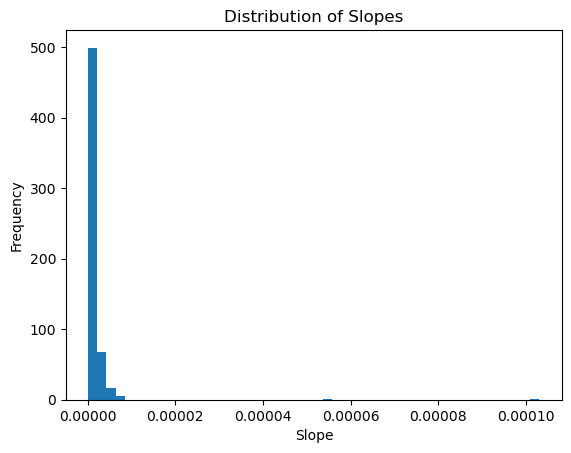

In [27]:
def calculate_slopes(ecg_signal, window_size=1100, fs=360):
    slopes = []
    for i in range(0, len(ecg_signal) - window_size, window_size):
        segment = ecg_signal[i:i+window_size]
        slope = np.max(np.abs(np.gradient(segment)))
        slopes.append(slope)
    return slopes

# Example usage:
slopes = calculate_slopes(final_ecg)
plt.hist(slopes, bins=50)
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.title('Distribution of Slopes')
plt.show()

# Choose a threshold based on histogram analysis
slope_th = np.percentile(slopes, 95)

In [131]:
slope_th

2.0945702372209686e-06

signal de longueur: 650000


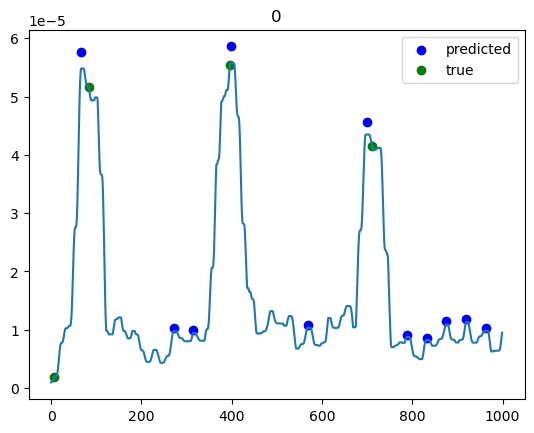

signal de longueur: 650000


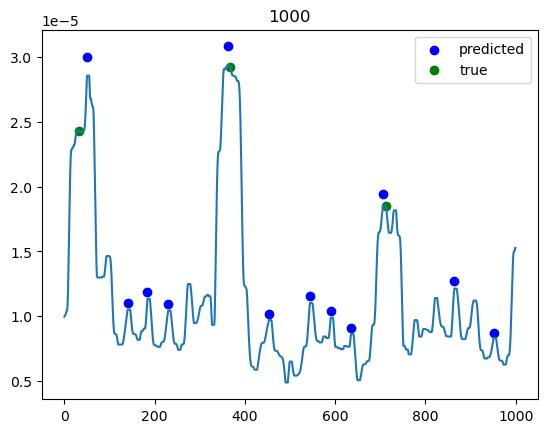

signal de longueur: 650000


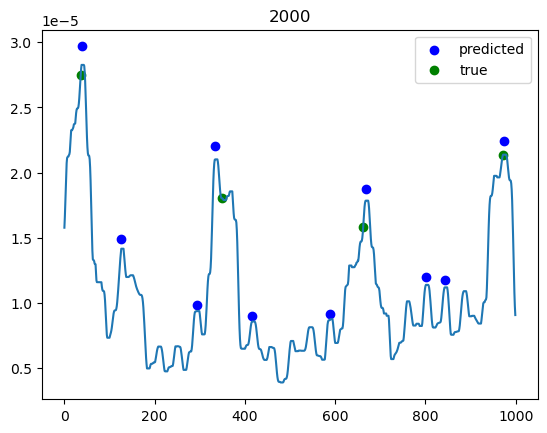

signal de longueur: 650000


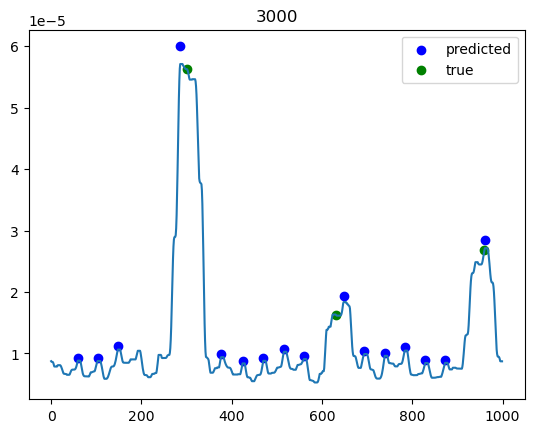

signal de longueur: 650000


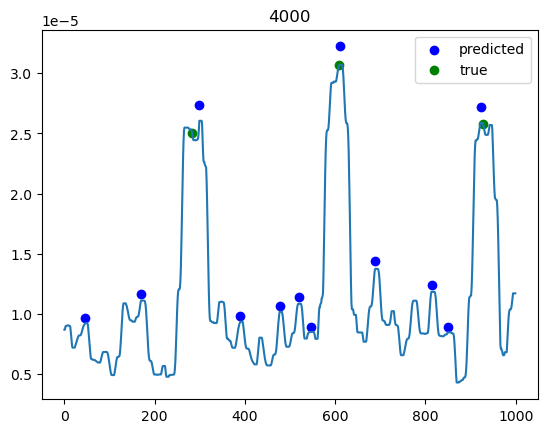

signal de longueur: 650000


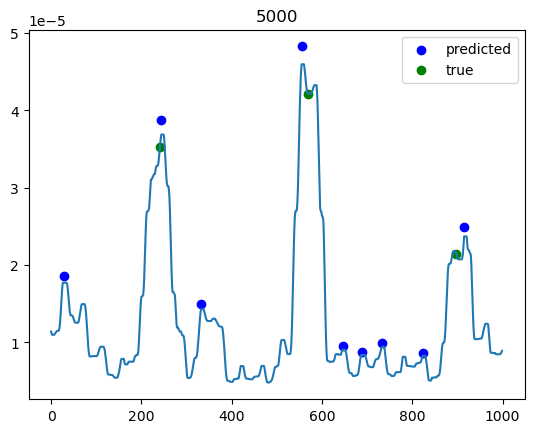

signal de longueur: 650000


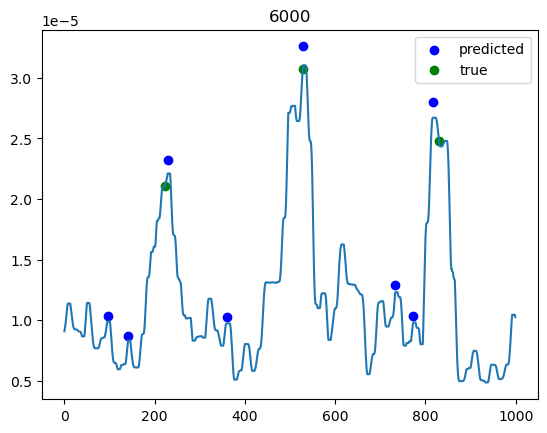

signal de longueur: 650000


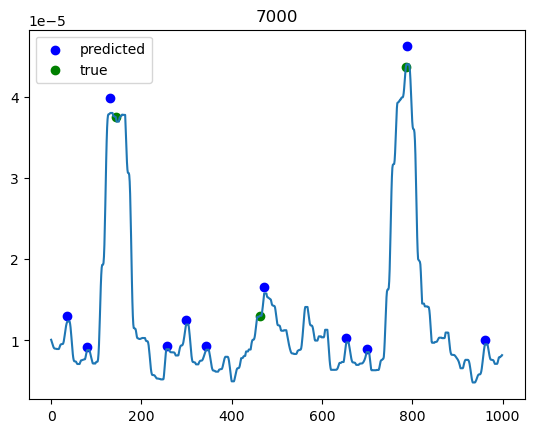

signal de longueur: 650000


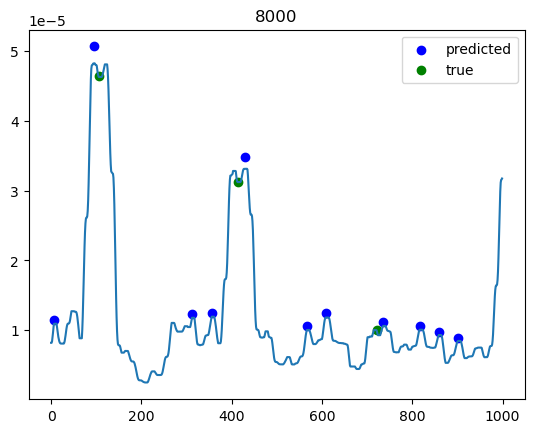

signal de longueur: 650000


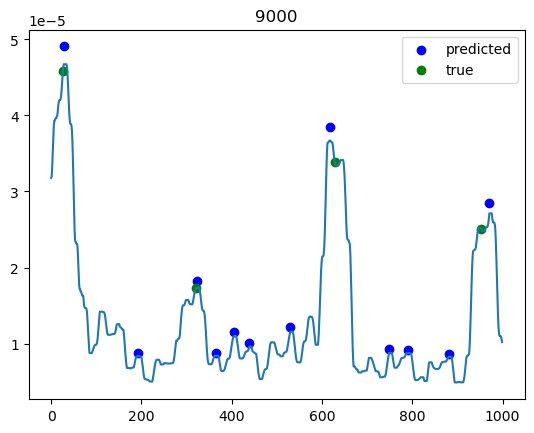

signal de longueur: 650000


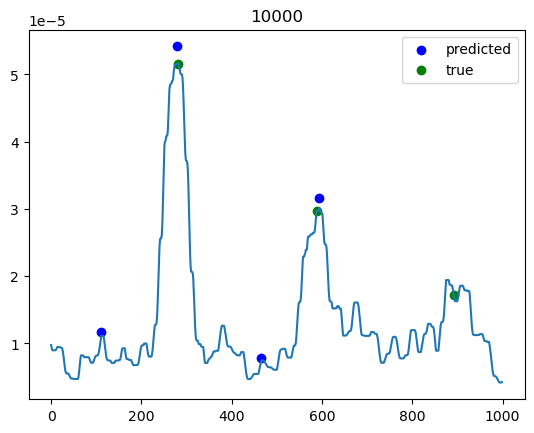

signal de longueur: 650000


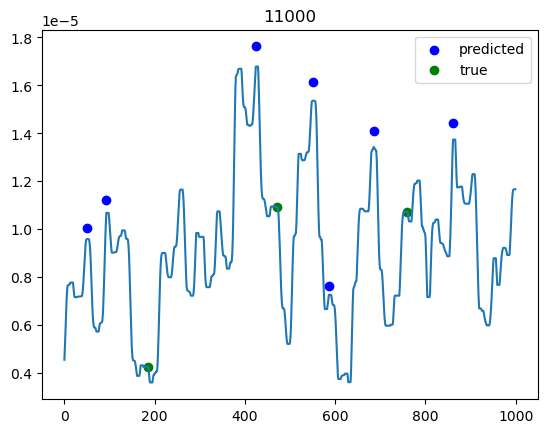

signal de longueur: 650000


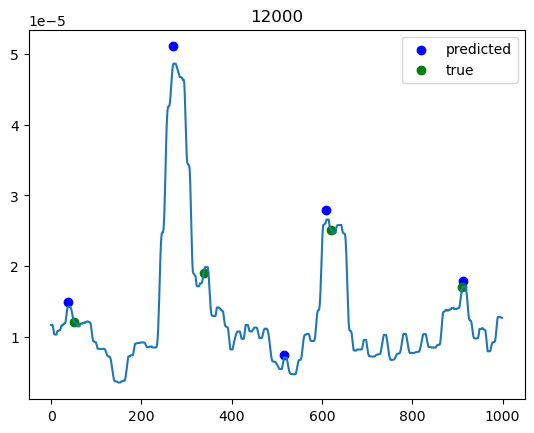

signal de longueur: 650000


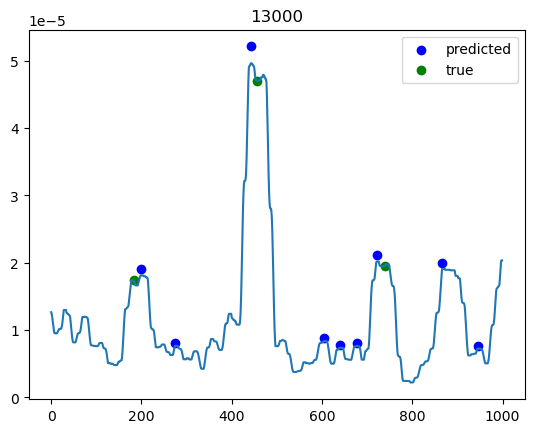

signal de longueur: 650000


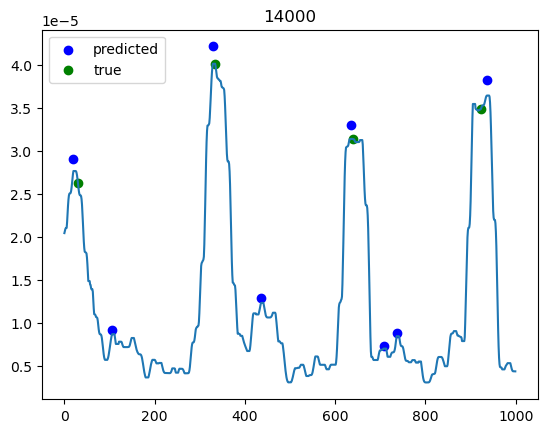

signal de longueur: 650000


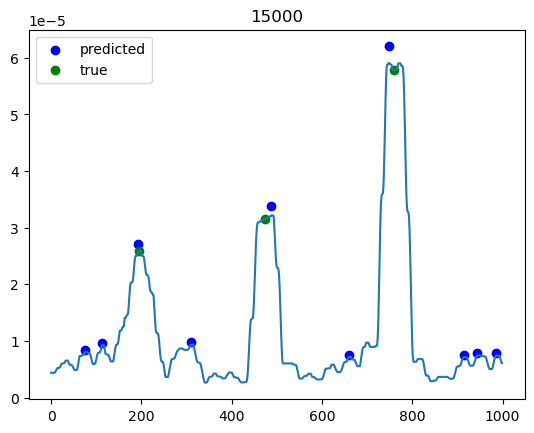

signal de longueur: 650000


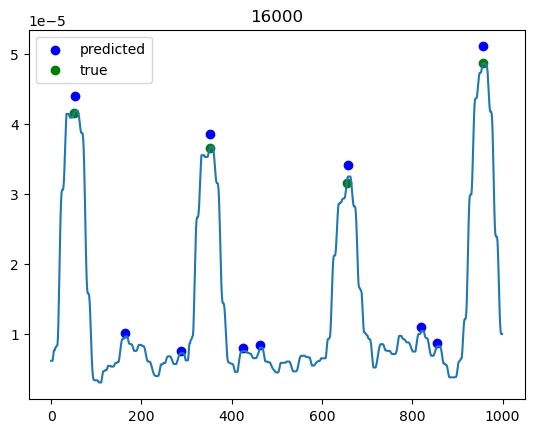

signal de longueur: 650000


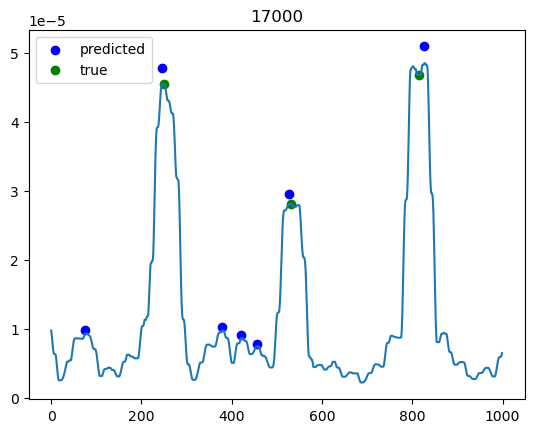

signal de longueur: 650000


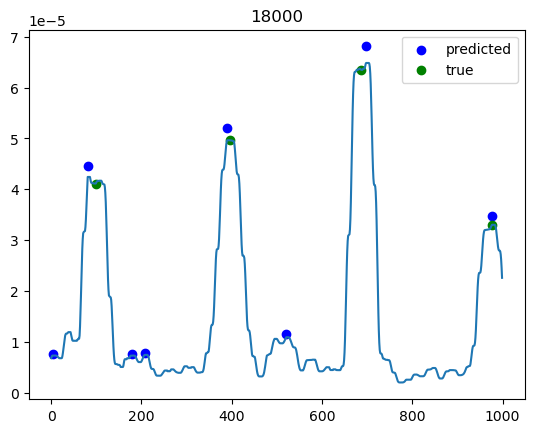

signal de longueur: 650000


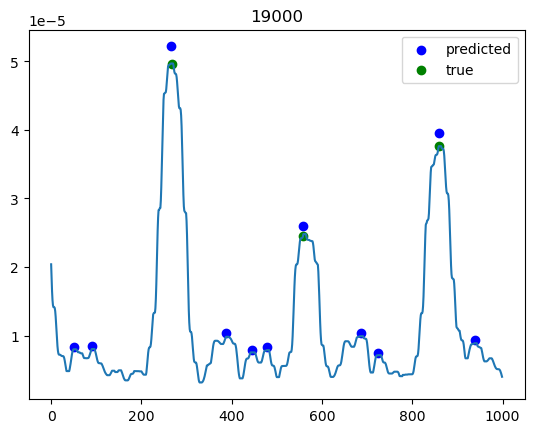

signal de longueur: 650000


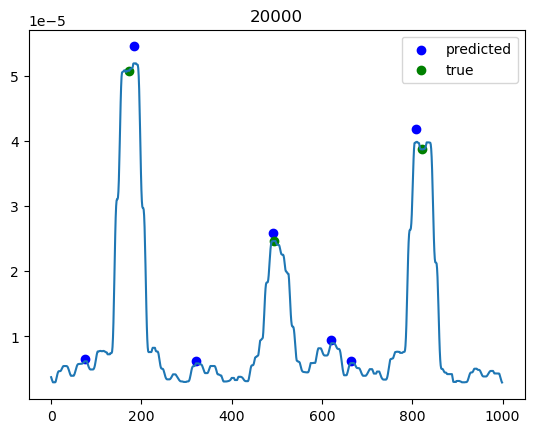

signal de longueur: 650000


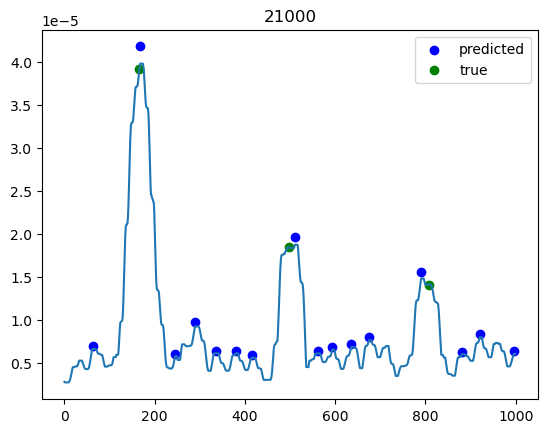

signal de longueur: 650000


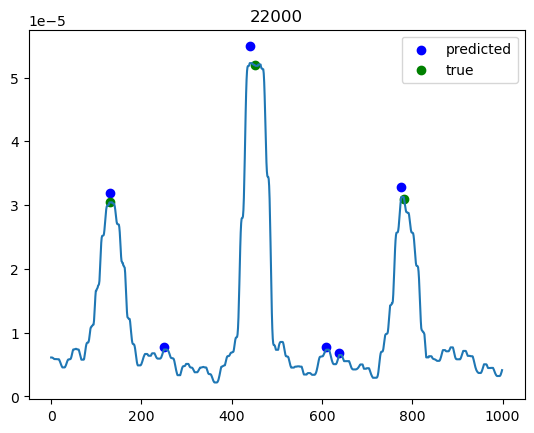

signal de longueur: 650000


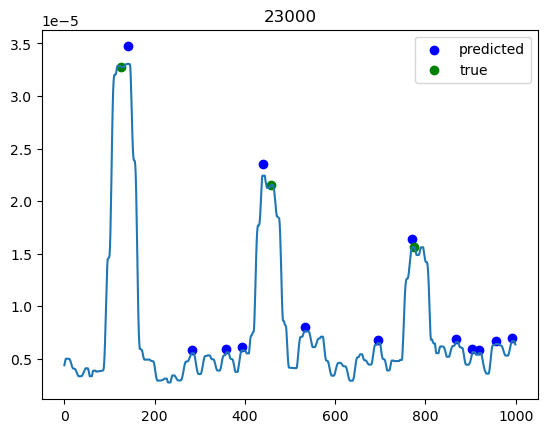

signal de longueur: 650000


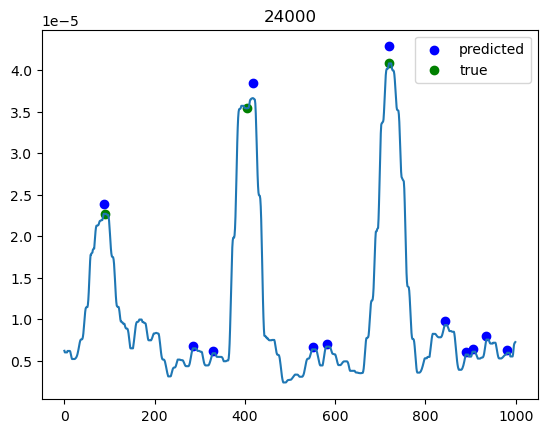

In [28]:
step = 1000
for zone_min in range(0, 25000, step): #len(final_ecg)
    zone_max = step + zone_min
    print_signal_qrs(final_ecg, #ecg_signal, #
                     group_qrs, 
                     QRS, 
                     mini = zone_min, 
                     maxi = zone_max, description = zone_min)

In [123]:
def find_r_peaks(x, Ath, slope_th, fs, TR):
    # Constants
    C = round(0.110 * fs)
    d = round(0.083 * fs)

    # Initialize Peaks array
    Peaks = []
    Peaks.append(TR[0])
    
    # Process each peak in TR
    for i in range(1, len(TR)):
        r0 = TR[i] - C
        r1 = TR[i] + C
        
        # Ensure indices are within bounds
        r0 = max(r0, 0)
        r1 = min(r1, len(x) - 1)
        
        # Determine the range and find the local max
        range_indices = range(r0, r1 + 1)
        maxVal, maxInd = max((x[j], j) for j in range_indices)
        TR[i] = maxInd
        
        # Determine dL and dR
        dL = TR[i] - range_indices[0]
        dR = range_indices[-1] - TR[i]
        
        # Calculate the slopes
        t_left = np.arange(TR[i] - dL, TR[i] + 1)
        t_right = np.arange(TR[i], TR[i] + dR + 1)
        
        #print(f"t_left = {t_left}")
        
        if len(t_left) == 1 or len(t_right) == 1:
            continue
        
        slope_l_max = max(np.gradient(x[t_left], t_left))
        slope_r_max = max(np.abs(np.gradient(x[t_right], t_right)))
        
        slope_min = min(slope_l_max, slope_r_max)
        
        # Calculate amplitude differences
        Delta_l = x[TR[i]] - x[max(TR[i] - d, 0)]
        Delta_r = x[min(TR[i] + d, len(x) - 1)] - x[TR[i]]
        
        # Check conditions
        if Delta_l > 0 and Delta_r < 0:
            A_th = fuzzy_c_median_clustering(x[min(0,i-5000):max(len(x), i+5000)])
            if x[TR[i]] > Ath:
                if TR[i] - TR[i-1] > 0.25 * fs:
                    if slope_min > slope_th:
                        Peaks.append(TR[i])
    
    return Peaks

In [135]:
Q_n = np.zeros(len(final_ecg))
Q_n[full_r_peaks] = final_ecg[full_r_peaks]

signal de longueur: 10000


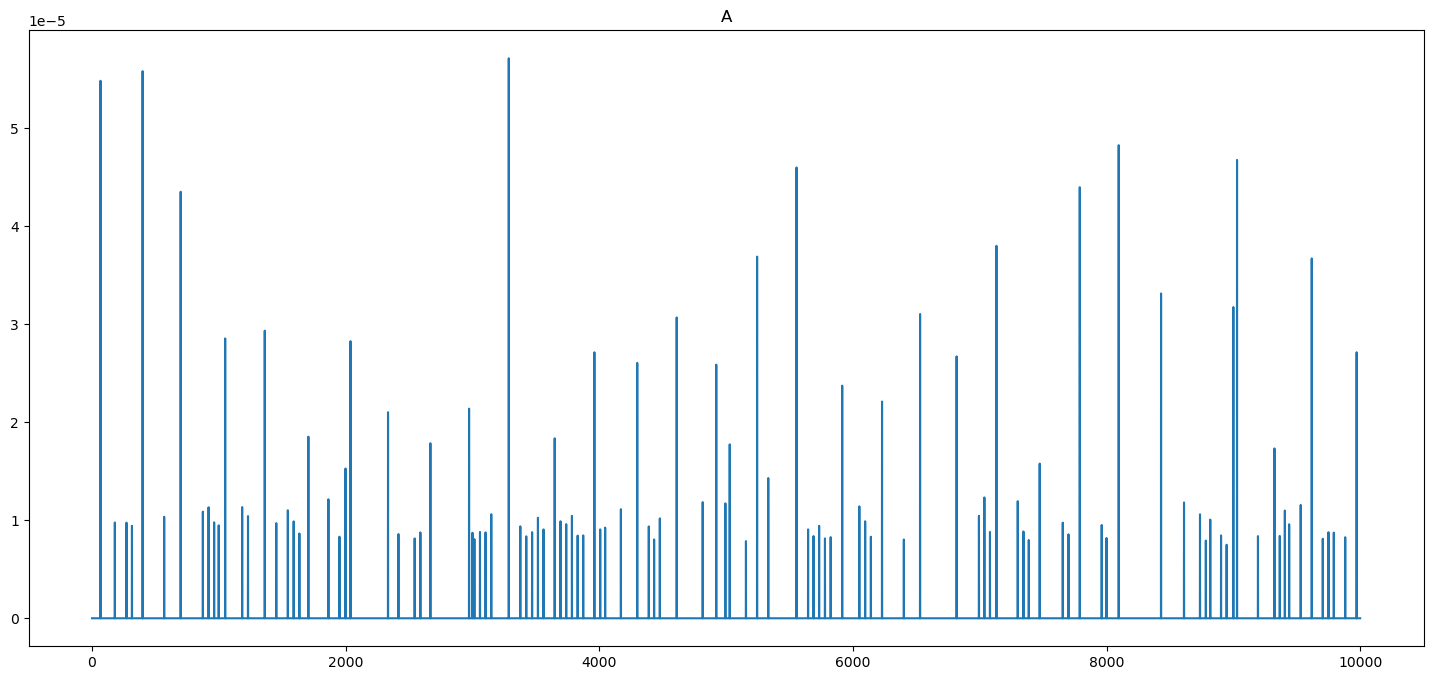

In [137]:
print_signal(Q_n[:10000])

In [143]:
full_r_peaks2 = regroup(final_ecg, np.array(full_r_peaks), 100)

In [144]:
QRS[:10]

[7, 83, 396, 711, 1032, 1368, 1712, 2036, 2349, 2662]

In [145]:
full_r_peaks2[:10]

[67, 399, 569, 699, 1050, 1184, 1362, 2038, 2334, 2668]

In [146]:
peaks = find_r_peaks(final_ecg, A_th, slope_th, fs, full_r_peaks2[:])

In [147]:
perf(QRS, peaks, 36, True)

(32,
 1841,
 1841,
 0.017084890549919914,
 [array([7]),
  array([396]),
  array([711]),
  array([1032]),
  array([1368]),
  array([1712]),
  array([2036]),
  array([2349]),
  array([2662]),
  array([2972]),
  array([3301]),
  array([3631]),
  array([3960]),
  array([4283]),
  array([4609]),
  array([4928]),
  array([5241]),
  array([5569]),
  array([5898]),
  array([6223]),
  array([6528]),
  array([6830]),
  array([7143]),
  array([7463]),
  array([7786]),
  array([8105]),
  array([8414]),
  array([8721]),
  array([9026]),
  array([9321]),
  array([9628]),
  array([9953]),
  array([10281]),
  array([10590]),
  array([10892]),
  array([11185]),
  array([11470]),
  array([11760]),
  array([12050]),
  array([12338]),
  array([12621]),
  array([12911]),
  array([13183]),
  array([13457]),
  array([13740]),
  array([14030]),
  array([14333]),
  array([14640]),
  array([14923]),
  array([15195]),
  array([15474]),
  array([16051]),
  array([16351]),
  array([16655]),
  array([16956]),
  arr

In [209]:
group_qrs = regroup(final_ecg, np.array(full_r_peaks), 100)

In [148]:
perf(QRS, full_r_peaks2, 36, True)

(1543,
 1422,
 1422,
 0.5204047217537943,
 [array([7]),
  array([569]),
  array([1184]),
  array([1712]),
  array([3631]),
  array([3960]),
  array([4170]),
  array([4815]),
  array([5898]),
  array([6401]),
  array([8610]),
  array([8721]),
  array([9193]),
  array([9321]),
  array([9953]),
  array([10378]),
  array([11093]),
  array([11185]),
  array([11424]),
  array([11470]),
  array([11550]),
  array([11685]),
  array([11760]),
  array([11861]),
  array([12271]),
  array([12338]),
  array([12431]),
  array([12911]),
  array([15310]),
  array([16164]),
  array([16820]),
  array([17250]),
  array([17378]),
  array([18208]),
  array([18521]),
  array([19686]),
  array([19971]),
  array([20321]),
  array([20621]),
  array([21063]),
  array([21498]),
  array([21808]),
  array([22250]),
  array([22610]),
  array([22885]),
  array([24285]),
  array([24582]),
  array([25155]),
  array([25573]),
  array([27124]),
  array([28243]),
  array([28966]),
  array([29592]),
  array([29918]),
  arr

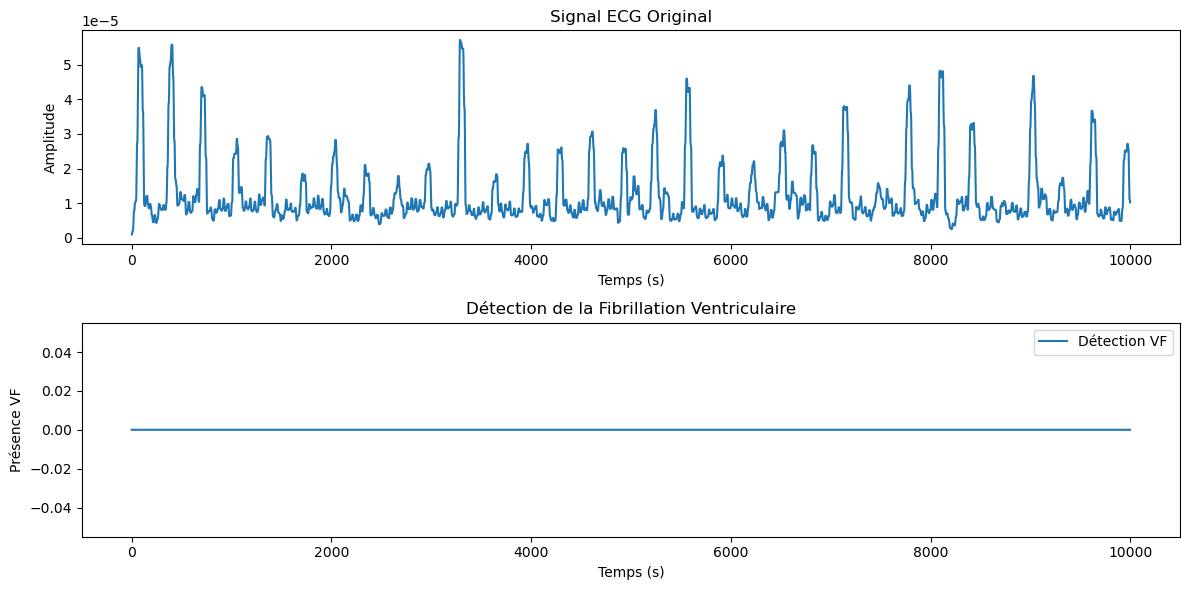

In [196]:
import numpy as np


def stft_analysis(signal, fs, window_size=256, hop_size=2, freq_range=(3, 4)):
    """
    Effectue une analyse STFT du signal donné et extrait les caractéristiques dans la bande de fréquences spécifiée.

    Args:
    - signal (array): Signal d'entrée.
    - fs (int): Fréquence d'échantillonnage.
    - window_size (int): Taille de la fenêtre pour la STFT.
    - hop_size (int): Décalage entre les fenêtres successives.
    - freq_range (tuple): Bande de fréquences d'intérêt (en Hz).

    Returns:
    - features (array): Caractéristiques moyennes dans la bande de fréquences spécifiée.
    - times (array): Temps correspondants aux fenêtres.
    """
    # Appliquer la fenêtre Blackman
    window = blackman(window_size)
    
    # Calculer la STFT
    f, t, Zxx = stft(signal, fs=fs, window=window, nperseg=window_size, noverlap=window_size-hop_size, nfft=window_size)
    
    # Indices correspondant à la bande de fréquences spécifiée
    freq_indices = np.where((f >= freq_range[0]) & (f <= freq_range[1]))[0]
    
    # Extraire les caractéristiques moyennes dans la bande de fréquences
    features = np.mean(np.abs(Zxx[freq_indices, :]), axis=0)
    
    return features, t

def detect_vf(signal, fs):
    """
    Détecte la fibrillation ventriculaire (VF) dans un signal donné.

    Args:
    - signal (array): Signal ECG d'entrée.
    - fs (int): Fréquence d'échantillonnage.

    Returns:
    - Q (array): Signal binaire indiquant la présence potentielle de VF.
    - times (array): Temps correspondants aux fenêtres.
    """
    # Paramètres pour l'analyse STFT
    window_size = 256
    hop_size = 2
    freq_range = (3, 4)  # Bande de fréquences 3-4 Hz
    
    # Extraction des caractéristiques
    S, times = stft_analysis(signal, fs, window_size, hop_size, freq_range)
    
    # Calculer la moyenne et l'écart-type
    m_s = np.mean(S)
    sigma_s = np.std(S)
    
    # Définir le seuil
    lambda_ = m_s + 3 * sigma_s
    
    # Détection de la présence potentielle de VF
    Q = np.where(S > lambda_, 1, 0)
    
    # Calcul de la skewness et de la kurtosis
    mu_3 = skew(S)
    kurt = kurtosis(S)
    
    # Appliquer les conditions de skewness et de kurtosis
    if abs(mu_3) > 3.5 and 8 <= kurt <= 17:
        return Q, times
    else:
        return np.zeros_like(Q), times


vf_signal, times = detect_vf(final_ecg, fs)

# Afficher les résultats
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(np.arange(10000), final_ecg[:10000])
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Signal ECG Original')

plt.subplot(2, 1, 2)
plt.plot(np.arange(10000), vf_signal[:10000], label='Détection VF')
plt.xlabel('Temps (s)')
plt.ylabel('Présence VF')
plt.title('Détection de la Fibrillation Ventriculaire')
plt.legend()

plt.tight_layout()
plt.show()

signal de longueur: 4320


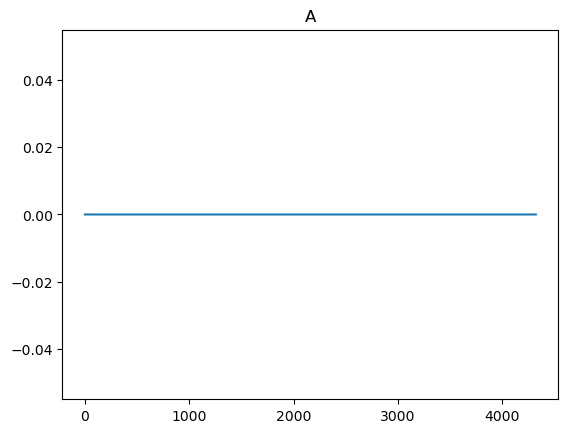

In [53]:
print_signal(vf_signal[mini:maxi])

In [54]:
vf_signal

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
r_peaks = qrs_localization(final_signal, fs, np.mean(final_signal))
#r_peaks = [a + 10 for a in r_peaks]

In [22]:
np.mean(final_signal)

0.00045819619690353033

In [ ]:
final_peaks = find_r_peaks(x, Ath, r_peaks, slope_th, fs)

In [23]:
perf(QRS, r_peaks, 36)

(693, 2966, 2968, 0.18934426229508197)

In [19]:
# x – the detection function waveform samples
# Ath – the amplitude threshold
# TR – vector of potential peaks
# slope_th – the slope threshold

def find_r_peaks(x, Ath, TR, slope_th, fs):
    C = round(0.110 * fs)
    d = round(0.083 * fs)
        
    Peaks = []
    n = 1 

    # Parcourir tous les pics potentiels TR
    for i in range(len(TR)):
        # Calculer les indices de la fenêtre autour du pic potentiel
        r0 = max(TR[i] - C, 0)
        r1 = min(TR[i] + C, len(x) - 1)
        
        # Trouver le maximum local dans cette fenêtre
        local_window = x[r0:r1 + 1]
        maxVal = np.max(local_window)
        maxInd = np.argmax(local_window)
        
        # Correction de la localisation du pic
        TR[i] = maxInd + r0
        
        # Calcul des deltas autour du pic
        delta_l_i = x[TR[i]] - x[max(TR[i] - d, 0)]
        delta_r_i = x[min(TR[i] + d, len(x) - 1)] - x[TR[i]]
        
        # Vérifier les conditions pour valider le pic
        if delta_l_i > 0 and delta_r_i < 0:
            if x[TR[i]] > Ath[TR[i]]:
                if i == 0 or (TR[i] - TR[i-1] > 0.25 * fs):
                    # Calcul des pentes maximales
                    t_left = x[max(TR[i] - C, 0):TR[i]]
                    t_right = x[TR[i]:min(TR[i] + C, len(x))]
                    
                    if len(t_left) > 1 and len(t_right) > 1:
                        slope_l_max = np.max(np.diff(t_left)) / (1/fs)
                        slope_r_max = np.max(np.abs(np.diff(t_right))) / (1/fs)
                        
                        slope_min = min(slope_l_max, slope_r_max)
                        
                        if slope_min > slope_th:
                            Peaks.append(TR[i])
                            n += 1

    return Peaks